In [289]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [290]:
data = pd.read_csv("loan_prediction.csv")
data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [291]:
data.shape

(614, 13)

In [292]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [293]:
data.size

7982

In [294]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [295]:
data.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [296]:
data= data.drop("Loan_ID",axis=1)

In [297]:
data['Loan_Status'].value_counts()


Loan_Status
Y    422
N    192
Name: count, dtype: int64

# Hundle the Mising Values

In [298]:
from sklearn.impute import SimpleImputer

# Fill numerical columns with median
num_imputer = SimpleImputer(strategy='median')
numerical_cols = ['CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])

In [299]:
# Fill categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = ['Gender','Dependents','Married' ,'Self_Employed']
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

In [300]:
data.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [301]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423,0.855049
std,6109.041673,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


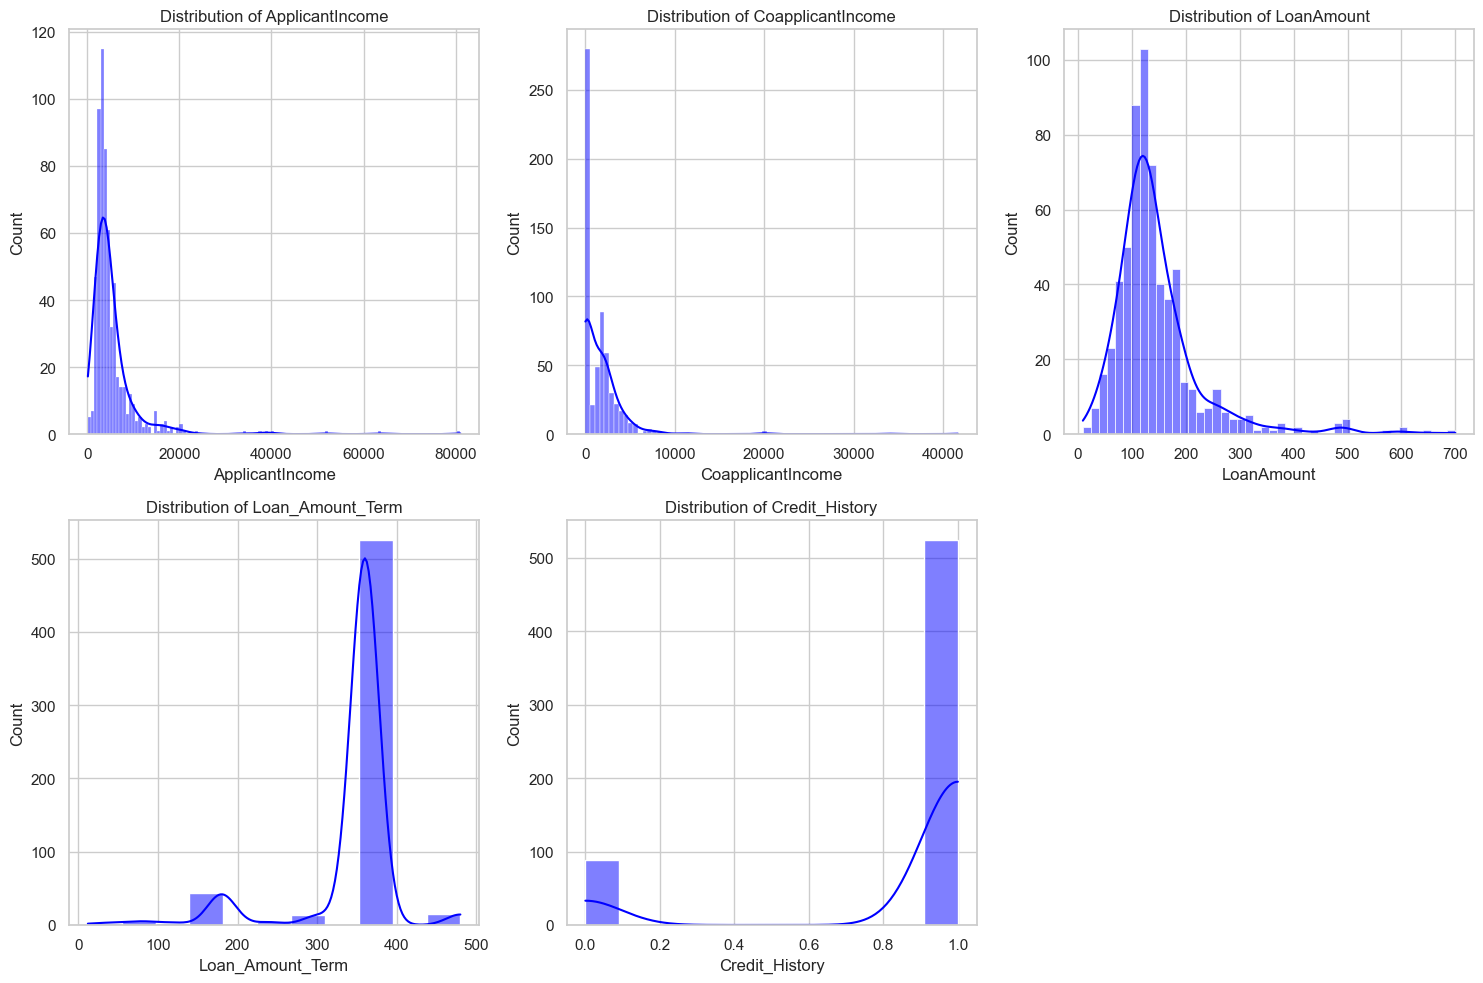

In [302]:
# List of numerical columns
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Plot histograms for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=data, x=col, kde=True, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()



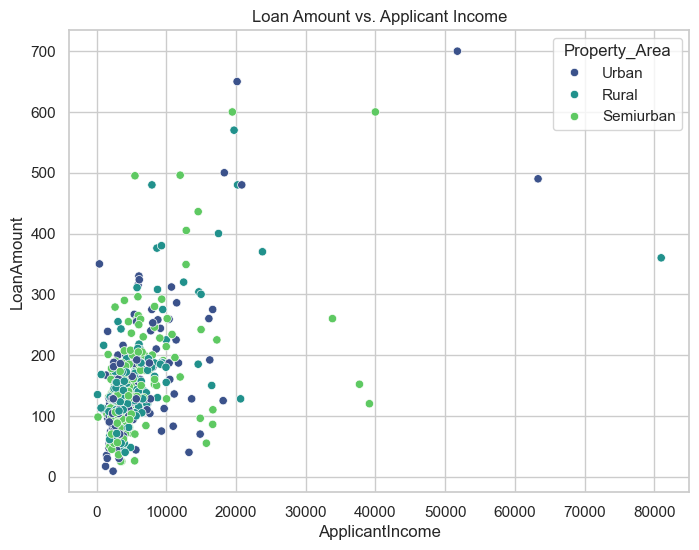

In [303]:
# Loan Amounts vs Applicant Income
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='ApplicantIncome', y='LoanAmount', hue='Property_Area', palette='viridis')
plt.title('Loan Amount vs. Applicant Income')
plt.show()

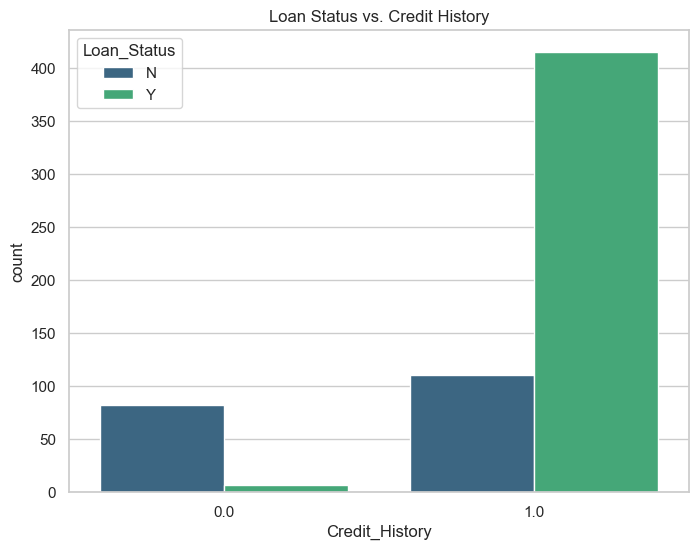

In [304]:
# Loan status (if avaible) vs credit history
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Credit_History', hue='Loan_Status', palette='viridis')
plt.title('Loan Status vs. Credit History')
plt.show()

In [305]:
data['Gender'] = data['Gender'].map({'Male':1,'Female':0}).astype('int')
data['Married'] = data['Married'].map({'Yes':1,'No':0}).astype('int')
data['Education'] = data['Education'].map({'Graduate':1,'Not Graduate':0}).astype('int')
data['Self_Employed'] = data['Self_Employed'].map({'Yes':1,'No':0}).astype('int')
data['Property_Area'] = data['Property_Area'].map({'Rural':0,'Semiurban':2,'Urban':1}).astype('int')
data['Loan_Status'] = data['Loan_Status'].map({'Y':1,'N':0}).astype('int')
data['Dependents'] =data['Dependents'].replace(to_replace="3+",value='4')


In [306]:
X = data.drop(columns=['Loan_Status'])  # Features
y = data['Loan_Status']  # Target

In [307]:
data.corr()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.364569,0.165877,-0.045364,-0.000525,0.058809,0.082912,0.106904,-0.074030,0.009170,-0.109521,0.017987
Married,0.364569,1.000000,0.308408,-0.012304,0.004489,0.051708,0.075948,0.146546,-0.100912,0.010938,0.007281,0.091478
Dependents,0.165877,0.308408,1.000000,-0.059001,0.048028,0.134080,0.034780,0.170584,-0.104059,-0.047203,-0.002768,0.002474
Education,-0.045364,-0.012304,-0.059001,1.000000,0.010383,0.140760,0.062290,0.168759,0.073928,0.073658,0.066740,0.085884
Self_Employed,-0.000525,0.004489,0.048028,0.010383,1.000000,0.127180,-0.016100,0.115100,-0.033739,-0.001550,-0.007124,-0.003700
ApplicantIncome,0.058809,0.051708,0.134080,0.140760,0.127180,1.000000,-0.116605,0.565181,-0.046531,-0.018615,-0.017321,-0.004710
CoapplicantIncome,0.082912,0.075948,0.034780,0.062290,-0.016100,-0.116605,1.000000,0.189218,-0.059383,0.011134,-0.019087,-0.059187
LoanAmount,0.106904,0.146546,0.170584,0.168759,0.115100,0.565181,0.189218,1.000000,0.036960,-0.000607,-0.027714,-0.033214
Loan_Amount_Term,-0.074030,-0.100912,-0.104059,0.073928,-0.033739,-0.046531,-0.059383,0.036960,1.000000,-0.004705,0.016086,-0.022549
Credit_History,0.009170,0.010938,-0.047203,0.073658,-0.001550,-0.018615,0.011134,-0.000607,-0.004705,1.000000,0.033102,0.540556


In [310]:
#Use SMOTE (Synthetic Minority Oversampling Technique) to balance the classes if the target variable is imbalanced.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new distribution of the target variable
print(pd.Series(y_resampled).value_counts())

Loan_Status
1    422
0    422
Name: count, dtype: int64


In [311]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [312]:
# Standardize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

In [313]:
print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

SVM Performance:
              precision    recall  f1-score   support

           0       0.93      0.68      0.79        94
           1       0.70      0.93      0.80        75

    accuracy                           0.79       169
   macro avg       0.81      0.81      0.79       169
weighted avg       0.83      0.79      0.79       169

Confusion Matrix:
[[64 30]
 [ 5 70]]


In [314]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}\n")

evaluate_model(y_test, y_pred_svm, "SVM")

SVM Performance:
Precision: 0.70, Recall: 0.93, F1 Score: 0.80

